<a href="https://colab.research.google.com/github/KennedyPutraKusumo/pydex/blob/master/examples/pydex_quickstart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Setting
Consider a steady-state system with 2 control variables $x_1, x_2$ and 1 response $y$. An order 1 polynomial response surface model is to be developed for the system. You are tasked with designing the experiments for calibrating the model. Use principles of optimal experiment design to design maximally informative experiments. Since the exact number of experiments to be ran is not specified, it is desirable to design an approximate experiment design.

$y = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \epsilon$,

where $\epsilon$ is the random error, normally distributed with zero mean and a given standard deviation $\sigma$.

In [7]:
!pip install pydex==0.0.3
!pip install numdifftools
!pip install cvxpy

# Step 1: import packages
The first step is to import the required packages. This comprises of pydex's designer class, and numpy.

In [8]:
from pydex.core.designer import Designer
import numpy as np

# Step 2: specify the model as a simulate function
Here, our system is a steady-state system with two experimental variables, and a single response. The model is specified as a Python function with a specific signature that needs to be followed strictly (order matters). Because we have a steady-state system, our simulate function will have two input arguments, ti_controls, and model_parameters. The input ti_controls will be a 1D numpy array, containing the values of the two experimental variables that pydex will pass into the simulate function. The input model_parameters will also be a 1D numpy array, containing values of the model parameters. The simulate function must return a numpy array, containing a single element, representing the model's predicted response for the given ti_controls, and model_parameters.

In [9]:
def simulate(ti_controls, model_parameters):
    return np.array([
        # constant term
        model_parameters[0] +
        # linear term
        model_parameters[1] * ti_controls[0]                    +
        model_parameters[2] * ti_controls[1]
    ])

# Step 3: instantiate a designer and declare the simulate function
To start solving the optimal experimental design problem, we create an instance of pydex's designer. Once instantiated, we will assign the simulate function we have just created to pydex.

In [13]:
designer_1 = Designer()
designer_1.simulate = simulate

To understand what is happening in a bit more detail. All created instances of pydex designers will come with pre-defined attributes and methods. One pre-defined method of interest here is the "simulate" method. This is meant to be overwritten. If this pre-defined method is not overwritten, pydex will raise a SyntaxError exception during initialization. This is a feature in pydex to remind you should you forget to specify the simulate function for your model.

# Step 4: specify nominal model parameter values
The response surface model for this example is a linear model (with respect to its model parameters). This means that the optimal design for the model is independent of the model parameter values. But, pydex still requires nominal model parameter values to be passed to the designer. You can pick any value, and it will not affect the result. For this example, we choose a value of 1 for all four model parameters. Getting the dimension of the model parameters defined here to be consistent with the dimension required in the simulate function is important.

In [14]:
designer_1.model_parameters = np.ones(4)

The syntax is again similar with specifying the simulate function. When instantiated, a designer will come with a pre-defined attribute named "model_parameters" that needs to be overwritten. We overwrite this with a 1D numpy array with all elements equal to one.

# Step 5: pass in experimental candidates to optimize over
This step is specific to how pydex solves optimal experiment design problems. Before proceeding, it is important to note that it is customary in optimal experiment design to normalize the experimental controls so they take values between -1 and 1.

For this example, since we have two experimental controls, we will need to generate a 2D numpy array with shapes $N_c \times 2$; where $N_c$ is the total number of experimental candidates. For simplicity, we will pass in candidates from a 2D mesh-centered grid with 11 levels in each dimension. This leads to a total of $11^2$ number of experimental candidates. To generate the required 2D numpy array, we will use pydex's convenient shortcut method: "enumerate_candidates".



In [15]:
tic = designer_1.enumerate_candidates(
    bounds=[
            [-1, 1],
            [-1, 1],
    ],
    levels=[
            11, 
            11,
    ],
)  # tic stands for time-invariant control

After generating the required tic array, we need to pass it on to pydex. Now, we overwrite the pre-defined attribute ti_controls_candidates.

In [16]:
designer_1.ti_controls_candidates = tic

# Step 6: initialize the designer
We have specified the model through the simulate function, and specified the experimental candidates through the overwriting the ti_controls_candidates attributes. We are ready to solve our experimental design problem.

Before the designer can be used to conduct any activity, it needs to be initialized. During initialization, the designer is going to do two things. First, check if there are any syntax errors made so far. Second, run a single simulation (using the first experimental candidate) to determine the number of responses (as defined in the simulate function).

During initialization, you will also have a choice to determine how verbal you want the designer to be as it conducts experiment design, or any other activity. This is done by setting the verbose value. Note: although you can assign any real values, verbose is recommended to be a positive integer. 0: silent, 1: overview, 2: detailed, 3: very detailed

In [17]:
designer_1.initialize(verbose=2)

Initialization complete: designer ready.
----------------------------------------------------------------------------------------------------
Number of model parameters              : 4
Number of candidates                    : 121
Number of responses                     : 1
Number of measured responses            : 1
Number of time-invariant controls       : 2


'ready'

# Step 7: design experiment

In [18]:
result = designer_1.design_experiment(designer_1.d_opt_criterion, write=False, optimizer="SCS")

############################### Computing Optimal Experiment Design ################################
Started on                              : 2020-09-09 10:17:04.647692
Criterion                               : d_opt_criterion
Pseudo-bayesian                         : False
Dynamic                                 : False
Time-invariant Controls                 : True
Time-varying Controls                   : False
Number of Candidates                    : 121
---------------------------------------[Sensitivity Analysis]---------------------------------------
[Candidate     13/121]: time elapsed            0.14 seconds.
[Candidate     26/121]: time elapsed            0.17 seconds.
[Candidate     39/121]: time elapsed            0.21 seconds.
[Candidate     52/121]: time elapsed            0.24 seconds.
[Candidate     65/121]: time elapsed            0.27 seconds.
[Candidate     78/121]: time elapsed            0.31 seconds.
[Candidate     91/121]: time elapsed            0.34 seconds.


# Step 8: view results



In [20]:
designer_1.print_optimal_candidates(write=False)


######################################## Optimal Candidates ########################################
Obtained on                             : 2020-09-09 10:17:30.370840
Criterion                               : d_opt_criterion
Pseudo-bayesian                         : False
Dynamic                                 : False
Time-invariant Controls                 : True
Time-varying Controls                   : False
Number of Candidates                    : 121
Number of Optimal Candidates            : 4
-------------------------------------------[Candidate 1]--------------------------------------------
                             Recommended Effort: 25.00% of experiments                              
Time-invariant Controls:
[-1. -1.]
-------------------------------------------[Candidate 11]-------------------------------------------
                             Recommended Effort: 25.00% of experiments                              
Time-invariant Controls:
[-1.  1.]
----------------

For this specific example, we expect a standard factorial design. Here, we present the design in the most familiar way to confirm that the design really is a factorial design.

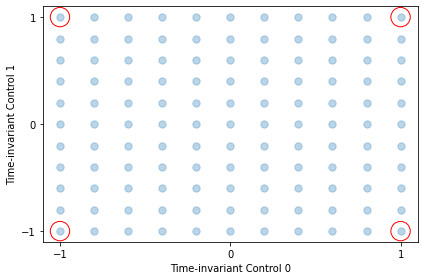

In [23]:
designer_1.plot_optimal_controls(non_opt_candidates=True)
designer_1.show_plots()